### Notebook to genereate boxplots for ddt(CWV) binned by cloud classification scheme.

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
12/15/23

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from read_functions import *

#### Main settings

In [2]:
# Size of new grid in nx x ny
nxx = 15 # n-points in both horizontal dimensions

storm = 'haiyan'
# storm = 'maria'

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_OFF','STRAT_OFF','STRATANVIL_ON']#,'crfon60h']
    tests_str = ['CTL','NCRF','STRATANV\nOFF','STRAT\nOFF','STRATANV\nON']#,'CRFON']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf36h','ncrf48h']
    tests_str = ['CTL','NCRF1','NCRF2']

time_neglect=12 # time steps from start to neglect

# Shift starting-read time step for CRFON comparison
t0_test=0
# if 'crfon' in tests[1]:
#     t0_test=24 # CRFON is restarted at t=24 in NCRF
    # memb0=5 # for CRFFON test

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
enstag = str(nmem)

In [3]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
nt=nt_data-time_neglect

In [4]:
################################################
#### NetCDF variable metadata

def var_regrid_metadata(nt,nx1_new,nx2_new):
    
    var_names = [
        'lat_new',
        'lon_new',
        'pclass_area',
        'rain',
        'qrain',
        'qrain_z',
        'qtotal',
        'pw',
        'pw_sat',
        'vmfu',
        'vmfd',
        'condh',
        'mse_vint',
        'lwacre',
        'swacre',
    ]
    descriptions = [
        'latitude of new grid',
        'longitude of new grid',
        'precip class area',
        'rain rate (centered diff)',
        'column integrated rain water mixr',
        'rain water mixr at lowest vertical level',
        'total integrated hydrometeor mixr',
        'precipitable water (aka CWV)',
        'saturation PW or CWV',
        'upward-masked mass flux vertically integrated (up to 100 hPa)',
        'downward-masked mass flux vertically integrated (up to 100 hPa)',
        'condensation heating from H_DIABATIC vertically int (up to 100 hPa), converted to rainfall units',
        'vertically int moist static energy, calculated as 1/g*integral(mse)dp up to 100 hPa',
        'LW column ACRE',
        'SW column ACRE',
    ]
    units = [
        'deg',
        'deg',
        '%',
        'mm/day',
        'mm',
        'kg/kg',
        'mm',
        'mm',
        'mm',
        'kg/m/s',
        'kg/m/s',
        'mm/day',
        'J/kg',
        'W/m^2',
        'W/m^2',
    ]
    dims2d = (nt,nx1_new,nx2_new)
    dim_names = ('nt','nx1_new','nx2_new')
    dims_set = [
        [('nx1_new',),(nx1_new,)],
        [('nx2_new',),(nx2_new,)],
        [(dim_names[0],'pclass',dim_names[1],dim_names[2]), (dims2d[0],6,dims2d[1],dims2d[2])],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
    ]

    len1=len(var_names); len2=len(descriptions); len3=len(units); len4=len(dims_set) #len4=len(dim_names)
    if (len1 != len2) or (len1 != len3) or (len1 != len4):
        raise ValueError("Variable info counts are off")

    return var_names, descriptions, units, dims_set

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
regrid_file = datdir+'regrid_diag_nx'+str(nxx)+'.nc'
ncfile = Dataset(regrid_file)
lat = ncfile.variables['lat_new'][:]
lon = ncfile.variables['lon_new'][:]
nx1 = lat.shape[0]
nx2 = lon.shape[0]
ncfile.close()

# Variable info
var_names, descriptions, units, dims_set = var_regrid_metadata(nt,nx1,nx2)

#### Main loops and compositing

In [5]:
# Main read loops for 3D (dependent) variables

ntest=len(tests)

allvars = []
# (itest, imemb, ivariable(ndarray))

for itest in range(ntest):

    test_str=tests[itest]
    print('Running test: ',test_str)

    if test_str == 'ctl':
        t0=time_neglect
    else:
        t0=0

    # Loop over ensemble members

    itest_ens = []
    for imemb in range(nmem):

        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        regrid_file = datdir+'regrid_diag_nx'+str(nxx)+'.nc'
        ncfile = Dataset(regrid_file)

        vars_imemb = []
        for ivar in var_names:
            vars_imemb.append(ncfile.variables[ivar][t0:,...])

        ncfile.close()

        itest_ens.append(vars_imemb)

    allvars.append(itest_ens)

Running test:  ctl
Running test:  ncrf36h
Running test:  STRATANVIL_OFF
Running test:  STRAT_OFF
Running test:  STRATANVIL_ON


---
### Plotting routines

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 11}

matplotlib.rc('font', **font)

In [7]:
def get_var(allvars, str_name):
    str_ind = var_names.index(str_name)
    var_np = []
    for itest in allvars:
        var_itest = []
        for imemb in itest:
            var_itest.append(imemb[str_ind])
        var_np.append(var_itest)
    # var_np=np.array(var_np)
    return var_np

---
#### Regression plots

In [8]:
def get_regression(var1, var2):
    reg = np.zeros((ntest,nmem))
    for itest in range(ntest):
        for imem in range(nmem):
            ireg = np.polyfit(var1[itest][imem].flatten(), var2[itest][imem].flatten(), deg=1)
            reg[itest,imem] = ireg[0]
    return reg

In [7]:
# Global boxplot settings

def regression_boxplot(invar, tests_str, title_tag, units, yscale='linear'):

    c_name = tests_str
    # cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue'][0:len(tests)]
    cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue'][0:len(tests)]
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    sns.boxplot([x for x in invar],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"2"})

    ax.set_yscale(yscale)
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    plt.title(title_tag)#, weight='bold')

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


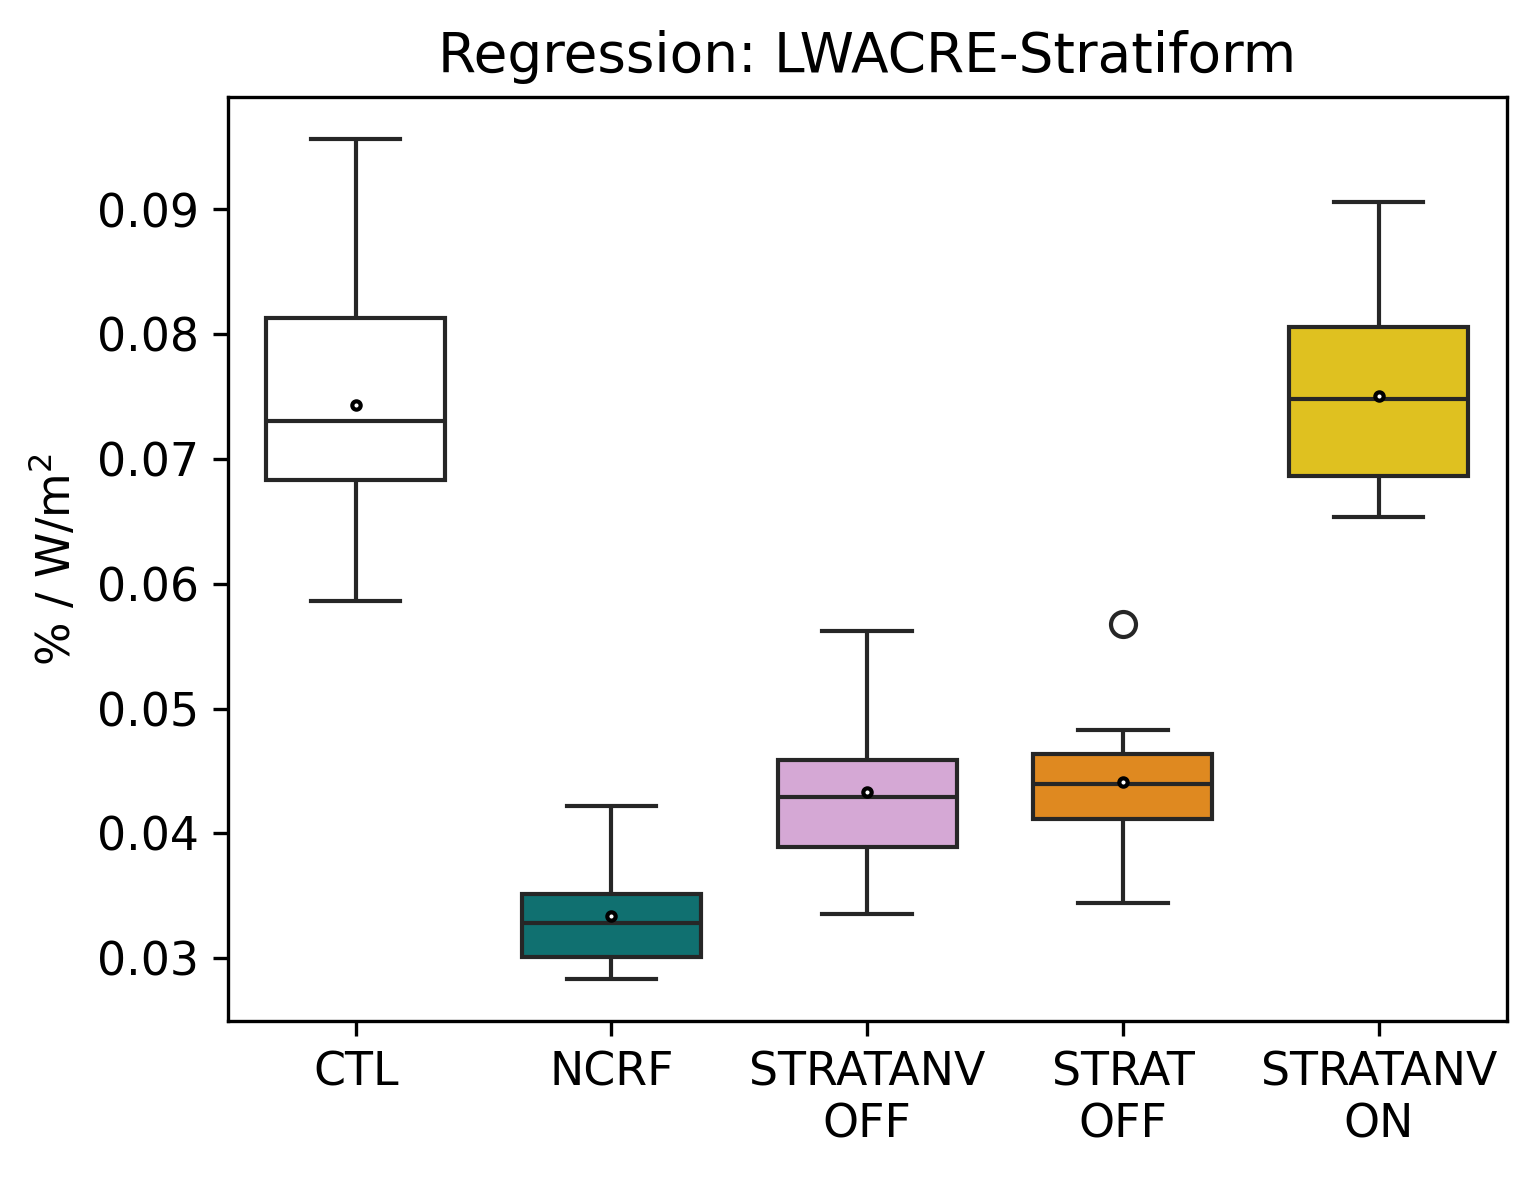

In [10]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: LWACRE-Stratiform'
units_bp = '% / W/m$^2$'

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

for itest in range(ntest):
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]

regression = get_regression(lwacre, pclass_area)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


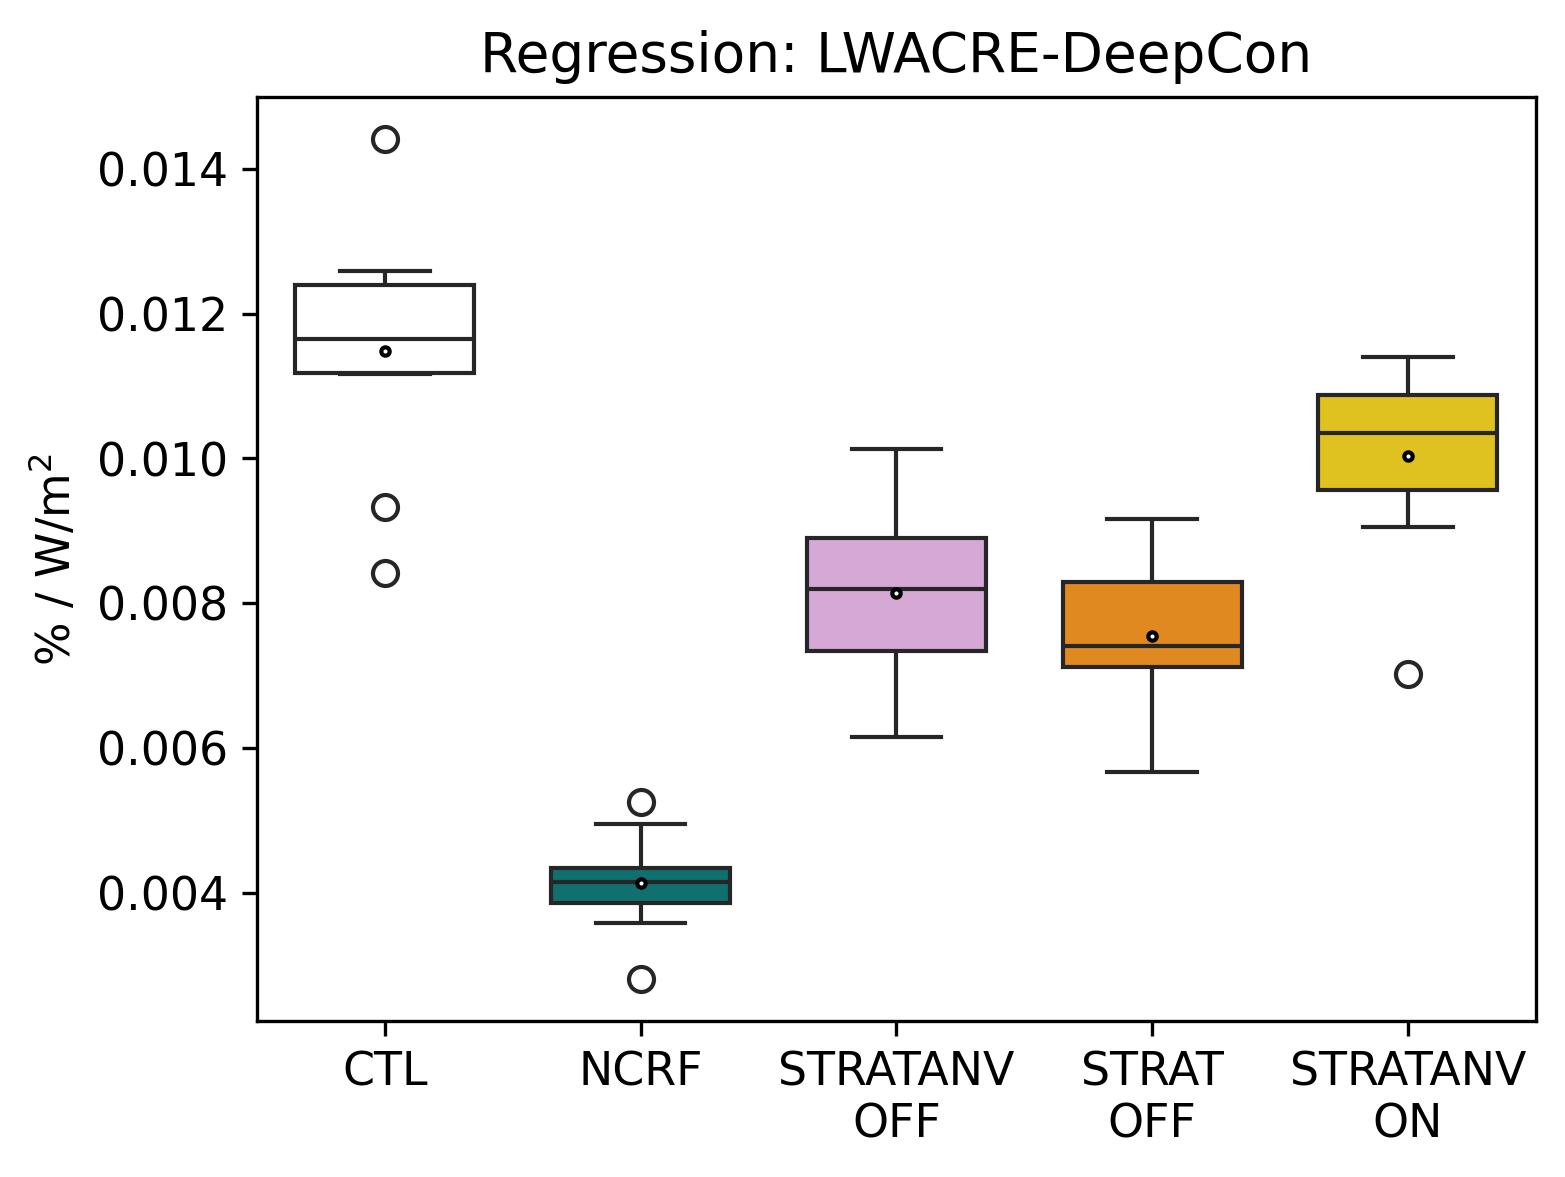

In [11]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: LWACRE-DeepCon'
units_bp = '% / W/m$^2$'

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 1 # deep conv

for itest in range(ntest):
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]

regression = get_regression(lwacre, pclass_area)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


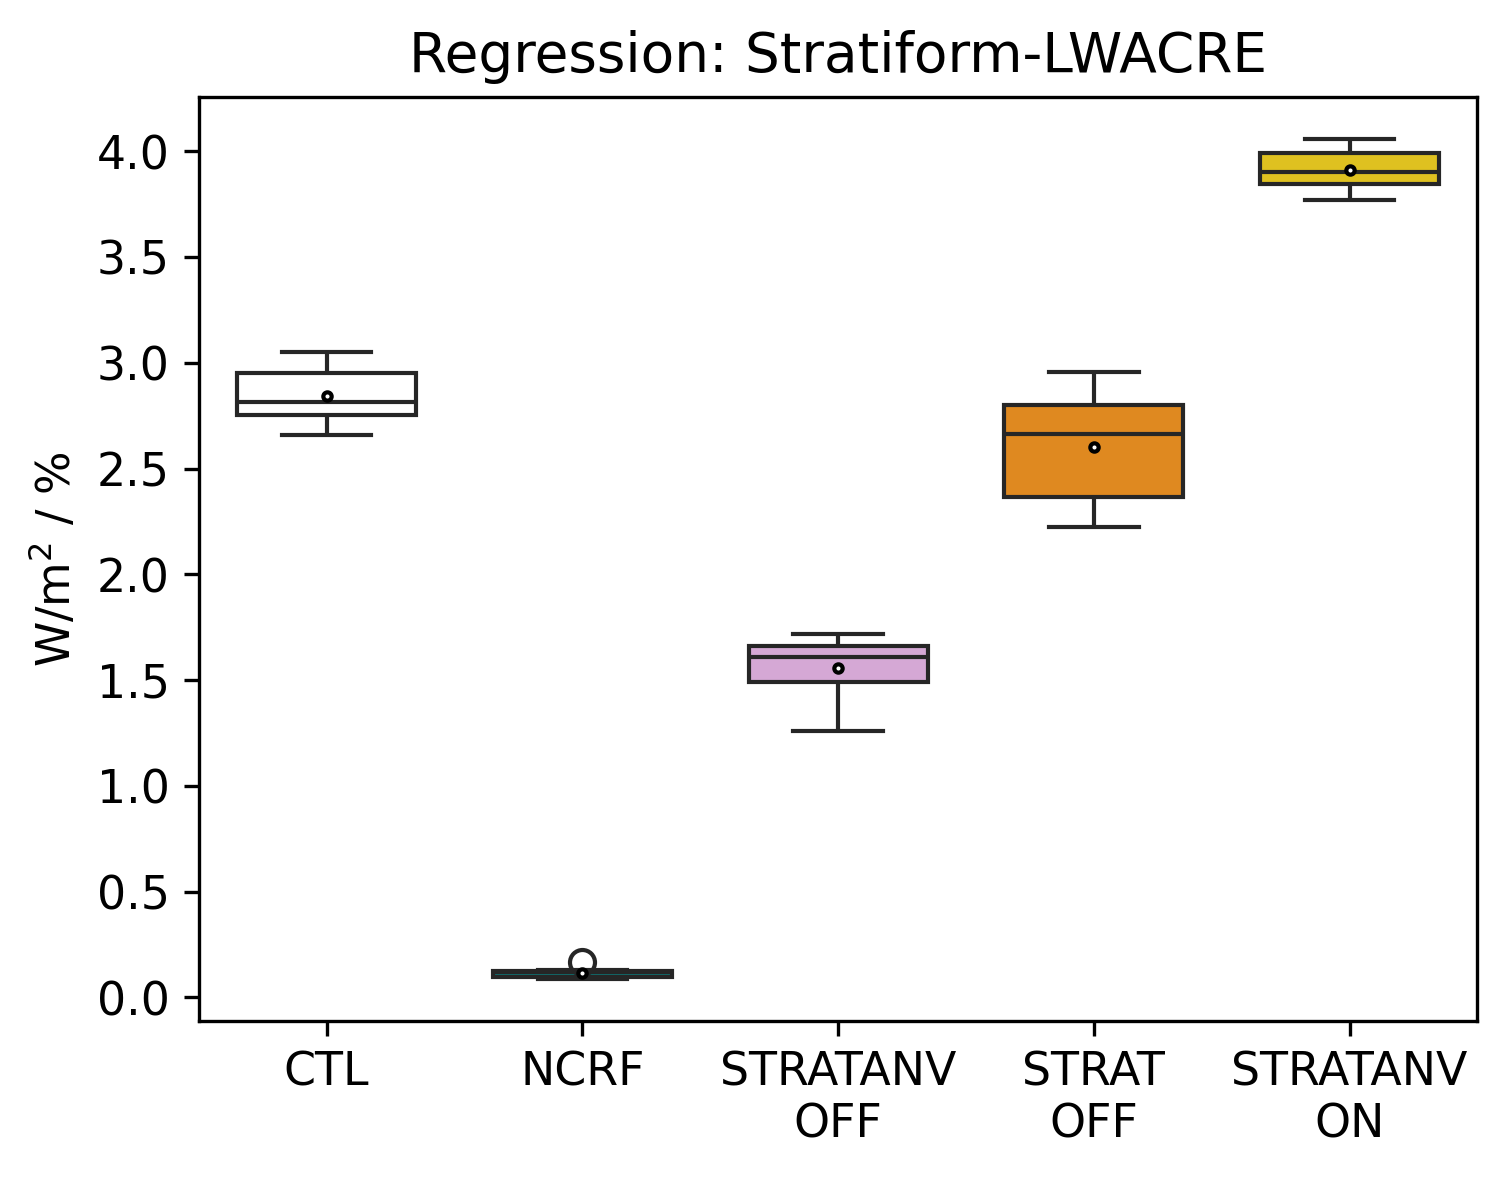

In [12]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: Stratiform-LWACRE'
units_bp = 'W/m$^2$ / %'

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

for itest in range(ntest):
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]

regression = get_regression(pclass_area, lwacre)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


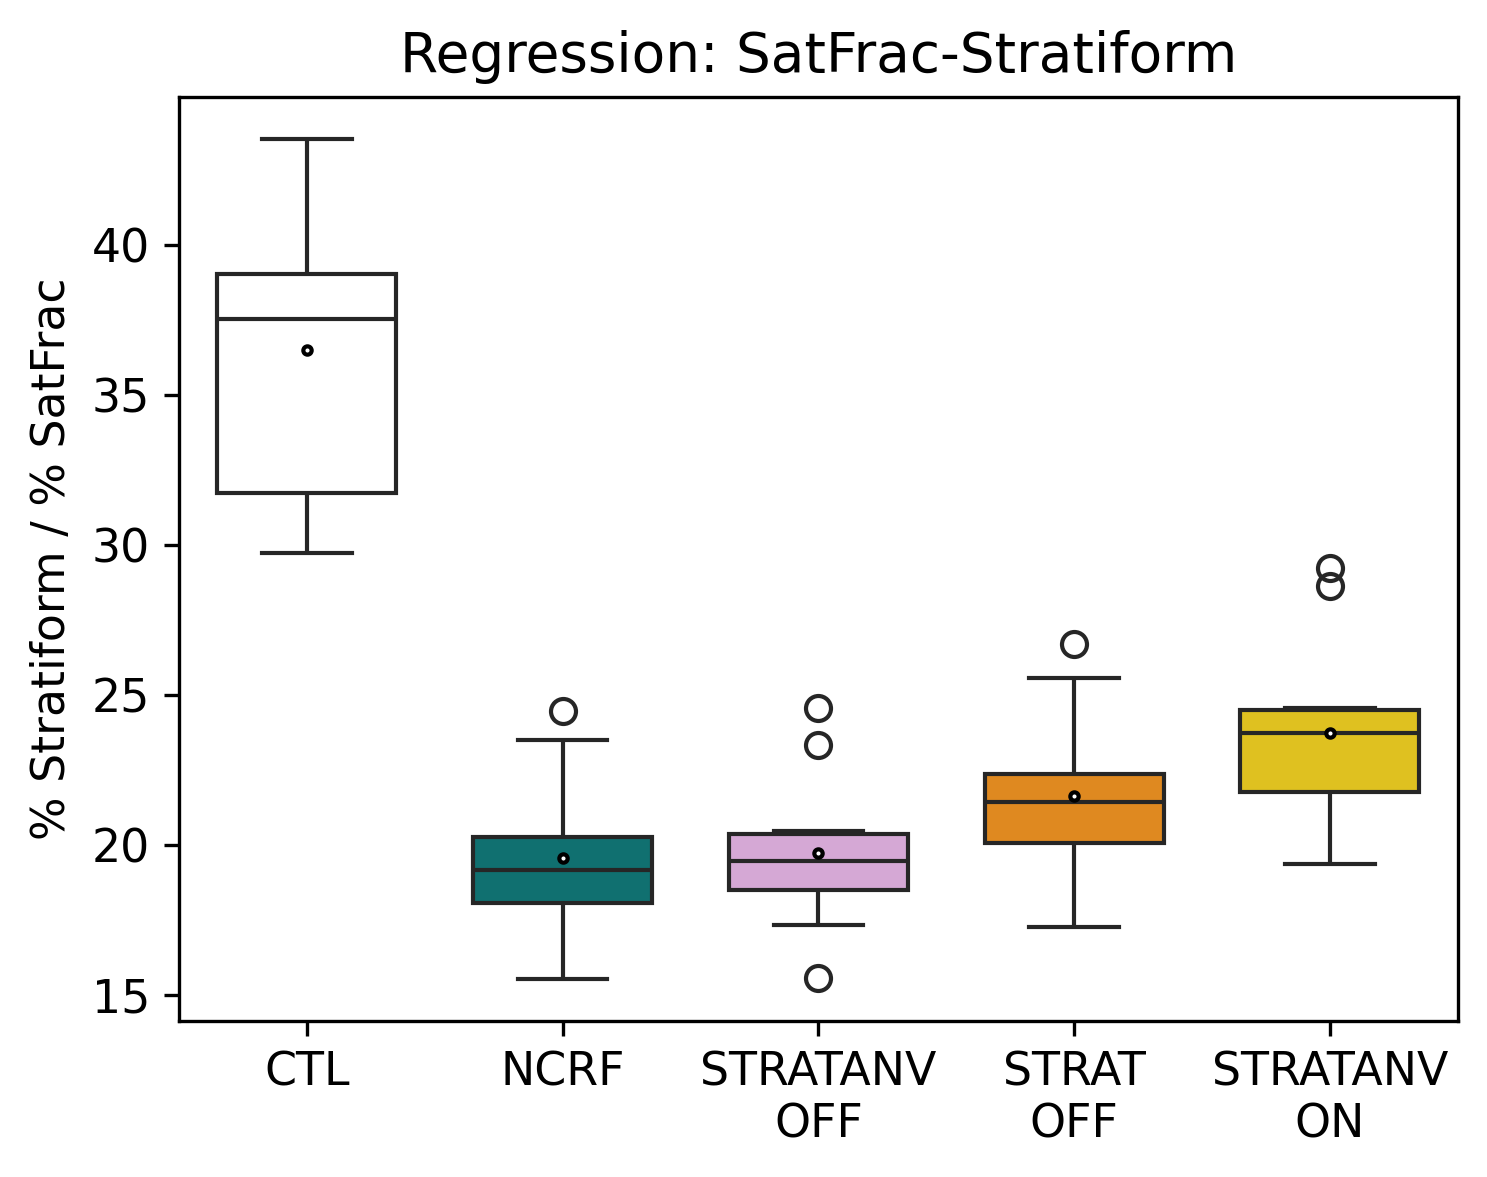

In [13]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: SatFrac-Stratiform'
units_bp = '% Stratiform / % SatFrac'

pw = get_var(allvars, 'pw')
pw_s = get_var(allvars, 'pw_sat')

pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

satfrac=[]
for itest in range(ntest):
    isatfrac=[]
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]
        isf = pw[itest][imemb]/pw_s[itest][imemb]
        isatfrac.append(isf)
    satfrac.append(isatfrac)

regression = get_regression(satfrac, pclass_area)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


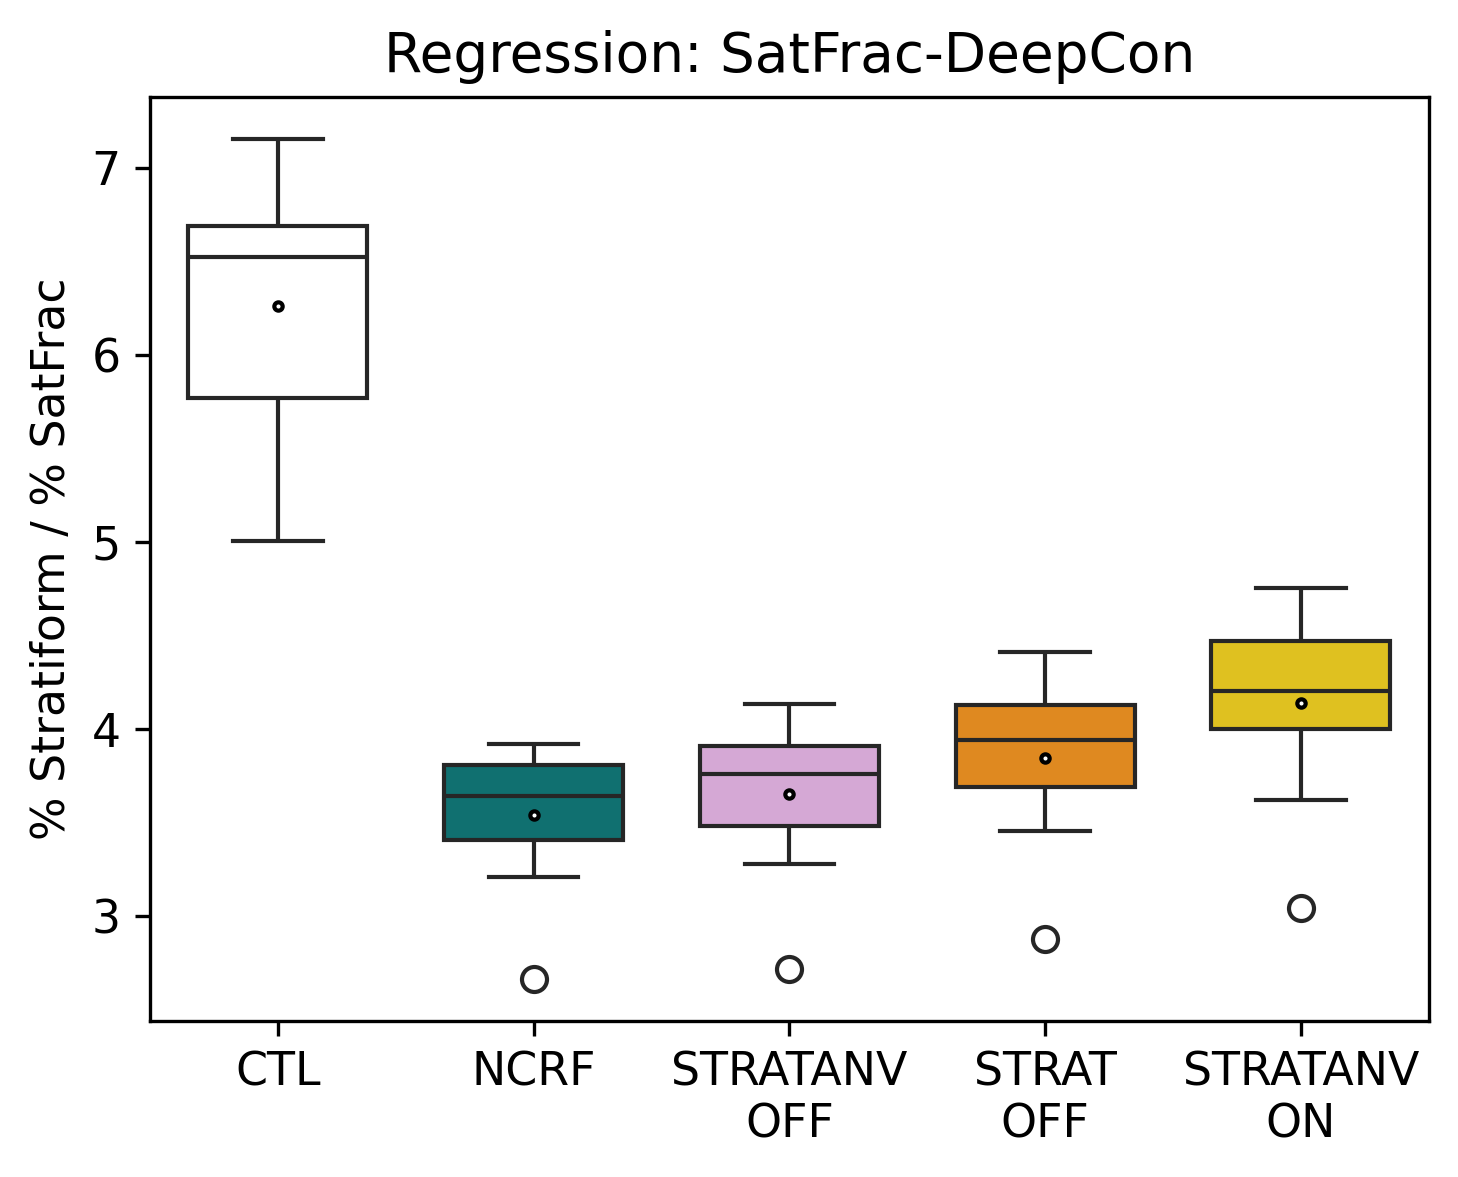

In [14]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: SatFrac-DeepCon'
units_bp = '% Stratiform / % SatFrac'

pw = get_var(allvars, 'pw')
pw_s = get_var(allvars, 'pw_sat')

pclass_area = get_var(allvars, 'pclass_area')
kclass = 1 # deep con

satfrac=[]
for itest in range(ntest):
    isatfrac=[]
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]
        isf = pw[itest][imemb]/pw_s[itest][imemb]
        isatfrac.append(isf)
    satfrac.append(isatfrac)

regression = get_regression(satfrac, pclass_area)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


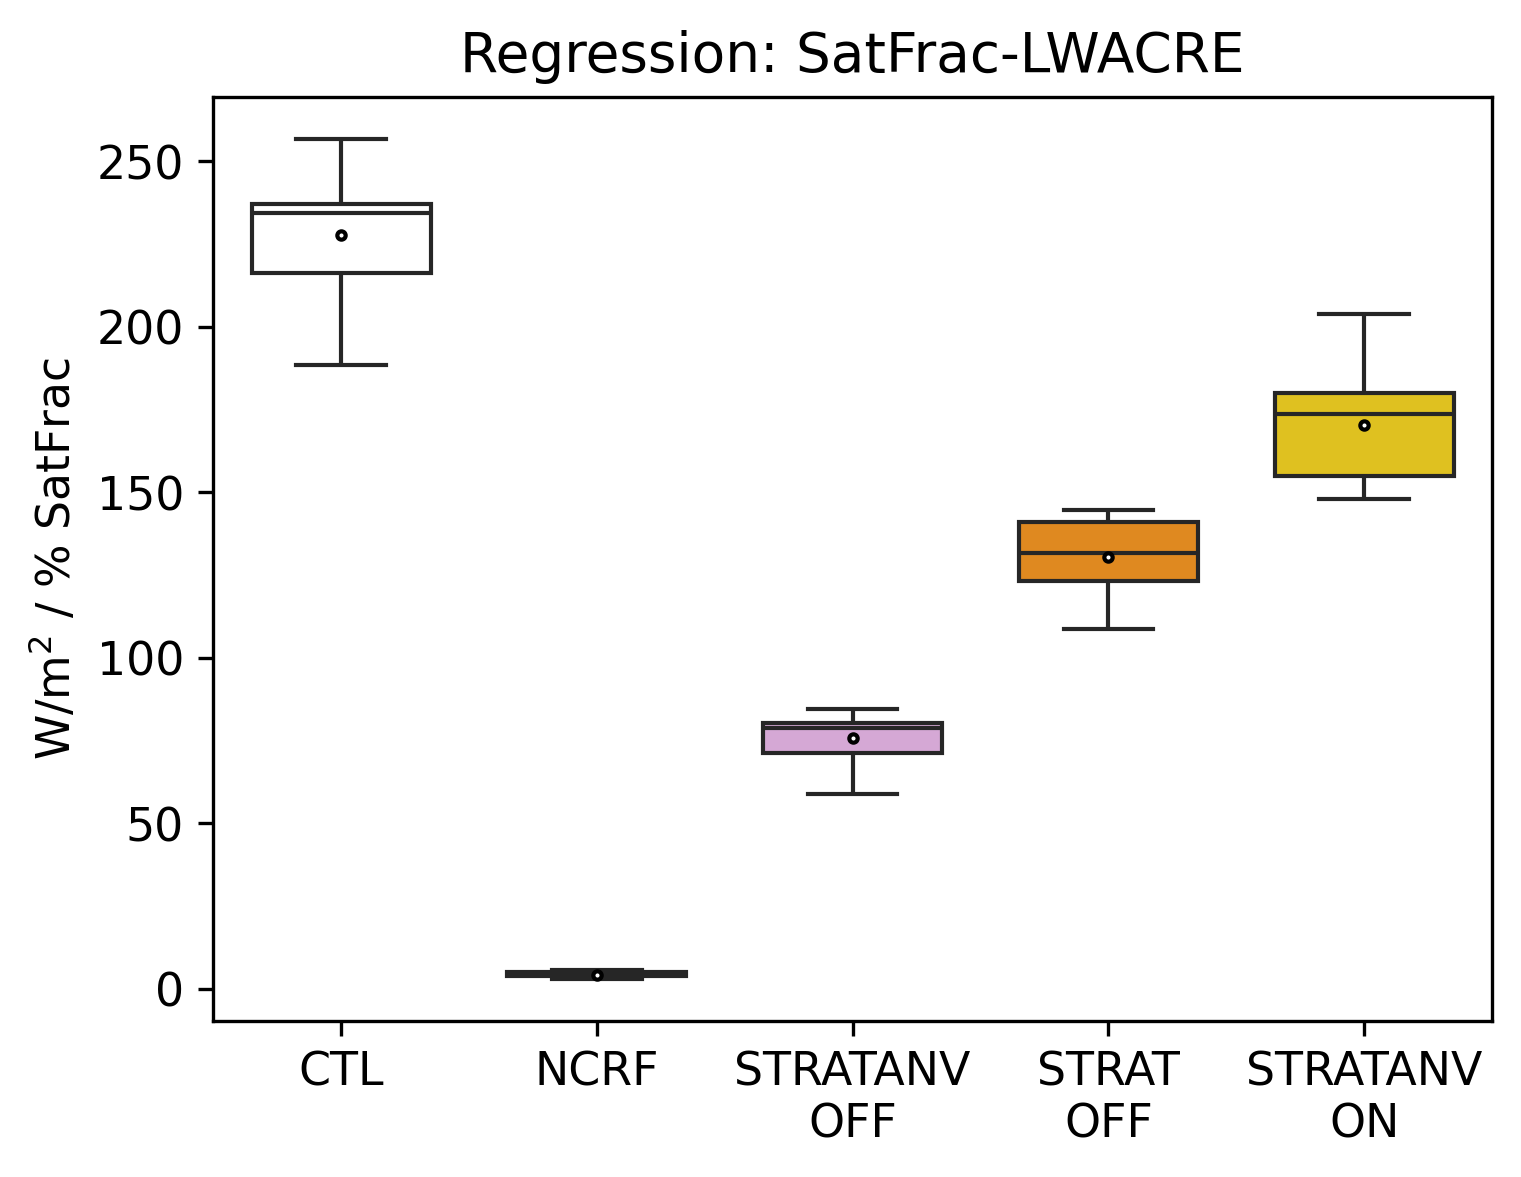

In [15]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: SatFrac-LWACRE'
units_bp = 'W/m$^2$ / % SatFrac'

pw = get_var(allvars, 'pw')
pw_s = get_var(allvars, 'pw_sat')

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

satfrac=[]
for itest in range(ntest):
    isatfrac=[]
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]
        isf = pw[itest][imemb]/pw_s[itest][imemb]
        isatfrac.append(isf)
    satfrac.append(isatfrac)

regression = get_regression(satfrac, lwacre)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


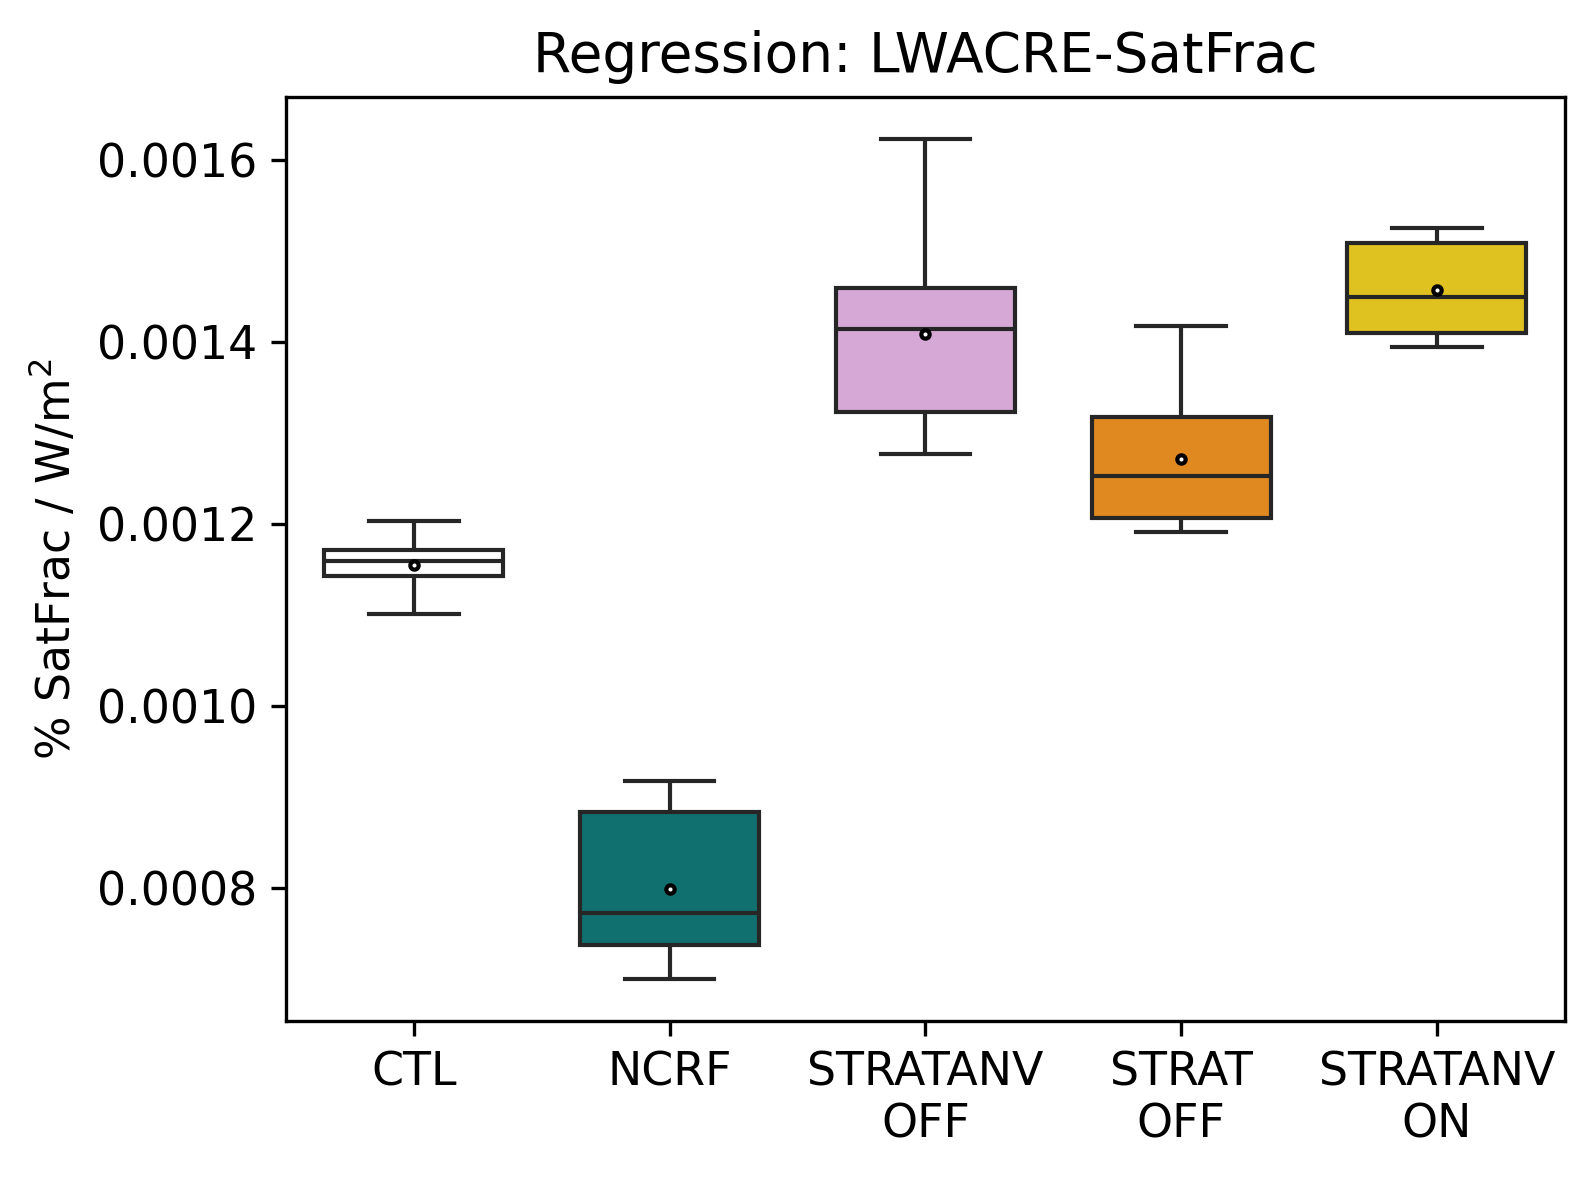

In [16]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: LWACRE-SatFrac'
units_bp = '% SatFrac / W/m$^2$'

pw = get_var(allvars, 'pw')
pw_s = get_var(allvars, 'pw_sat')

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

satfrac=[]
for itest in range(ntest):
    isatfrac=[]
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]
        isf = pw[itest][imemb]/pw_s[itest][imemb]
        isatfrac.append(isf)
    satfrac.append(isatfrac)

regression = get_regression(lwacre, satfrac)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


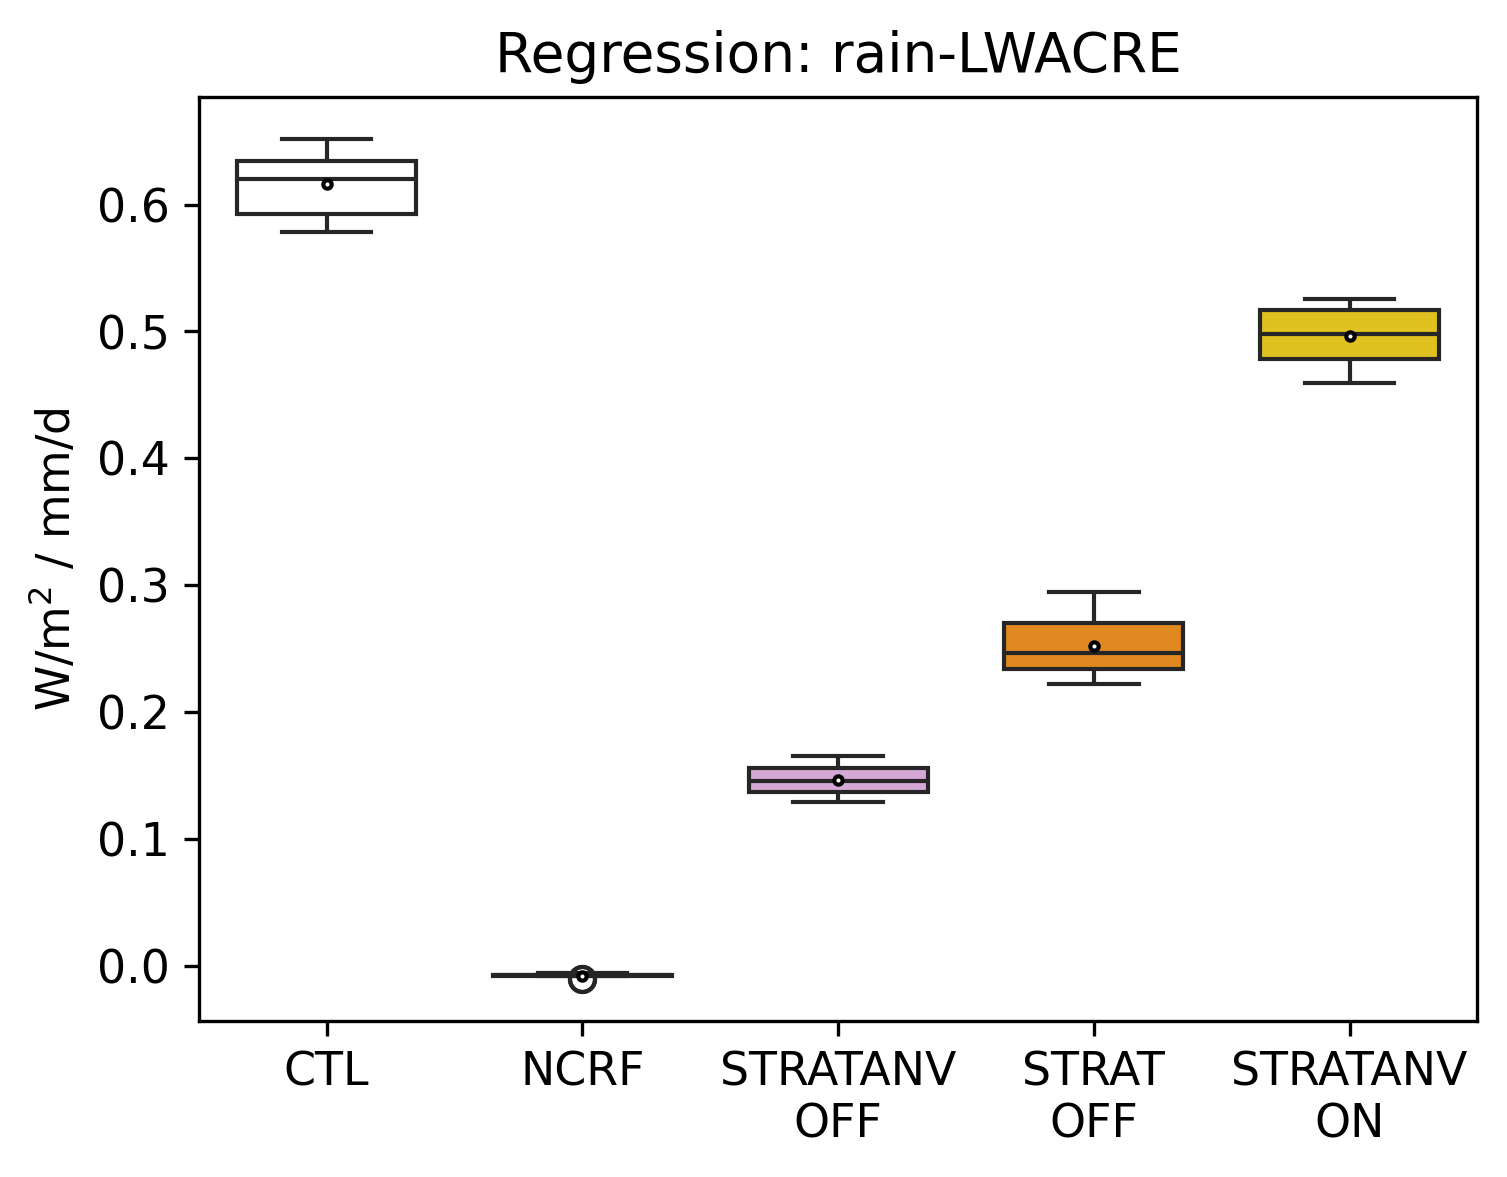

In [17]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: rain-LWACRE'
units_bp = 'W/m$^2$ / mm/d'

pw = get_var(allvars, 'pw')
pw_s = get_var(allvars, 'pw_sat')

rain = get_var(allvars, 'rain')

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

satfrac=[]
for itest in range(ntest):
    isatfrac=[]
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]
        isf = pw[itest][imemb]/pw_s[itest][imemb]
        isatfrac.append(isf)
    satfrac.append(isatfrac)

regression = get_regression(rain, lwacre)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


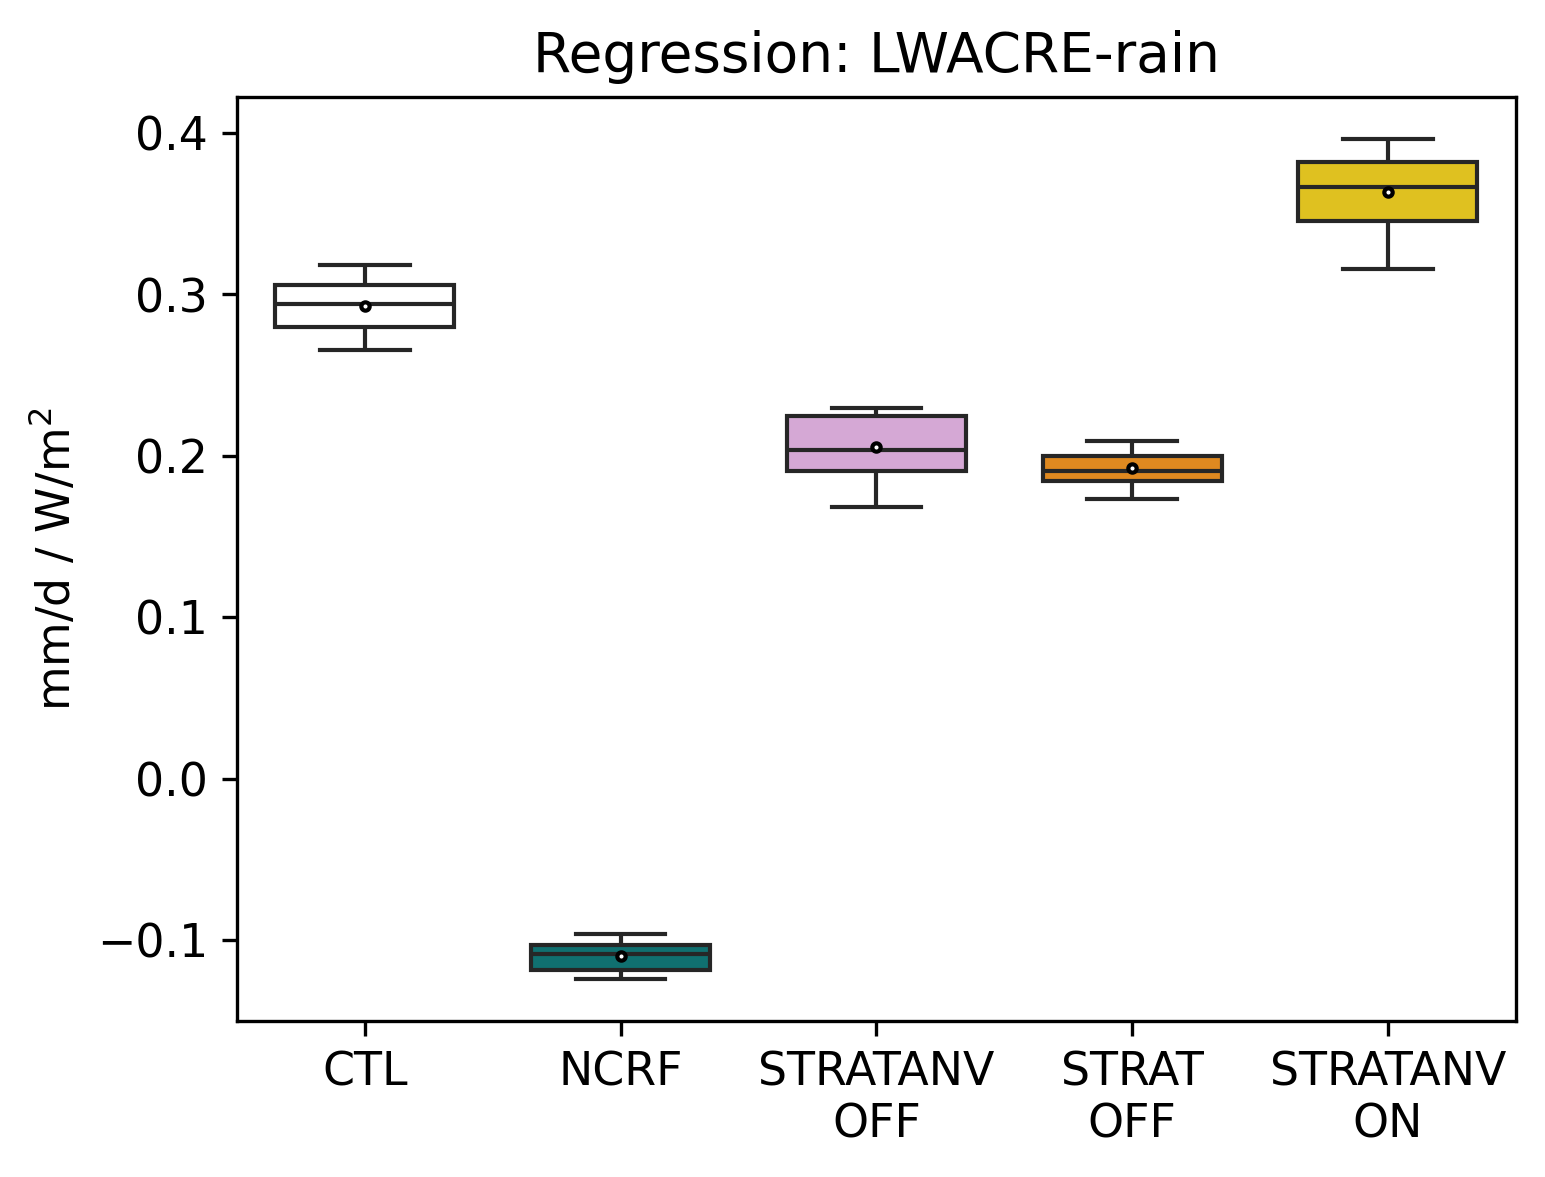

In [18]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: LWACRE-rain'
units_bp = 'mm/d / W/m$^2$'

pw = get_var(allvars, 'pw')
pw_s = get_var(allvars, 'pw_sat')

rain = get_var(allvars, 'rain')

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

satfrac=[]
for itest in range(ntest):
    isatfrac=[]
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]
        isf = pw[itest][imemb]/pw_s[itest][imemb]
        isatfrac.append(isf)
    satfrac.append(isatfrac)

regression = get_regression(lwacre, rain)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


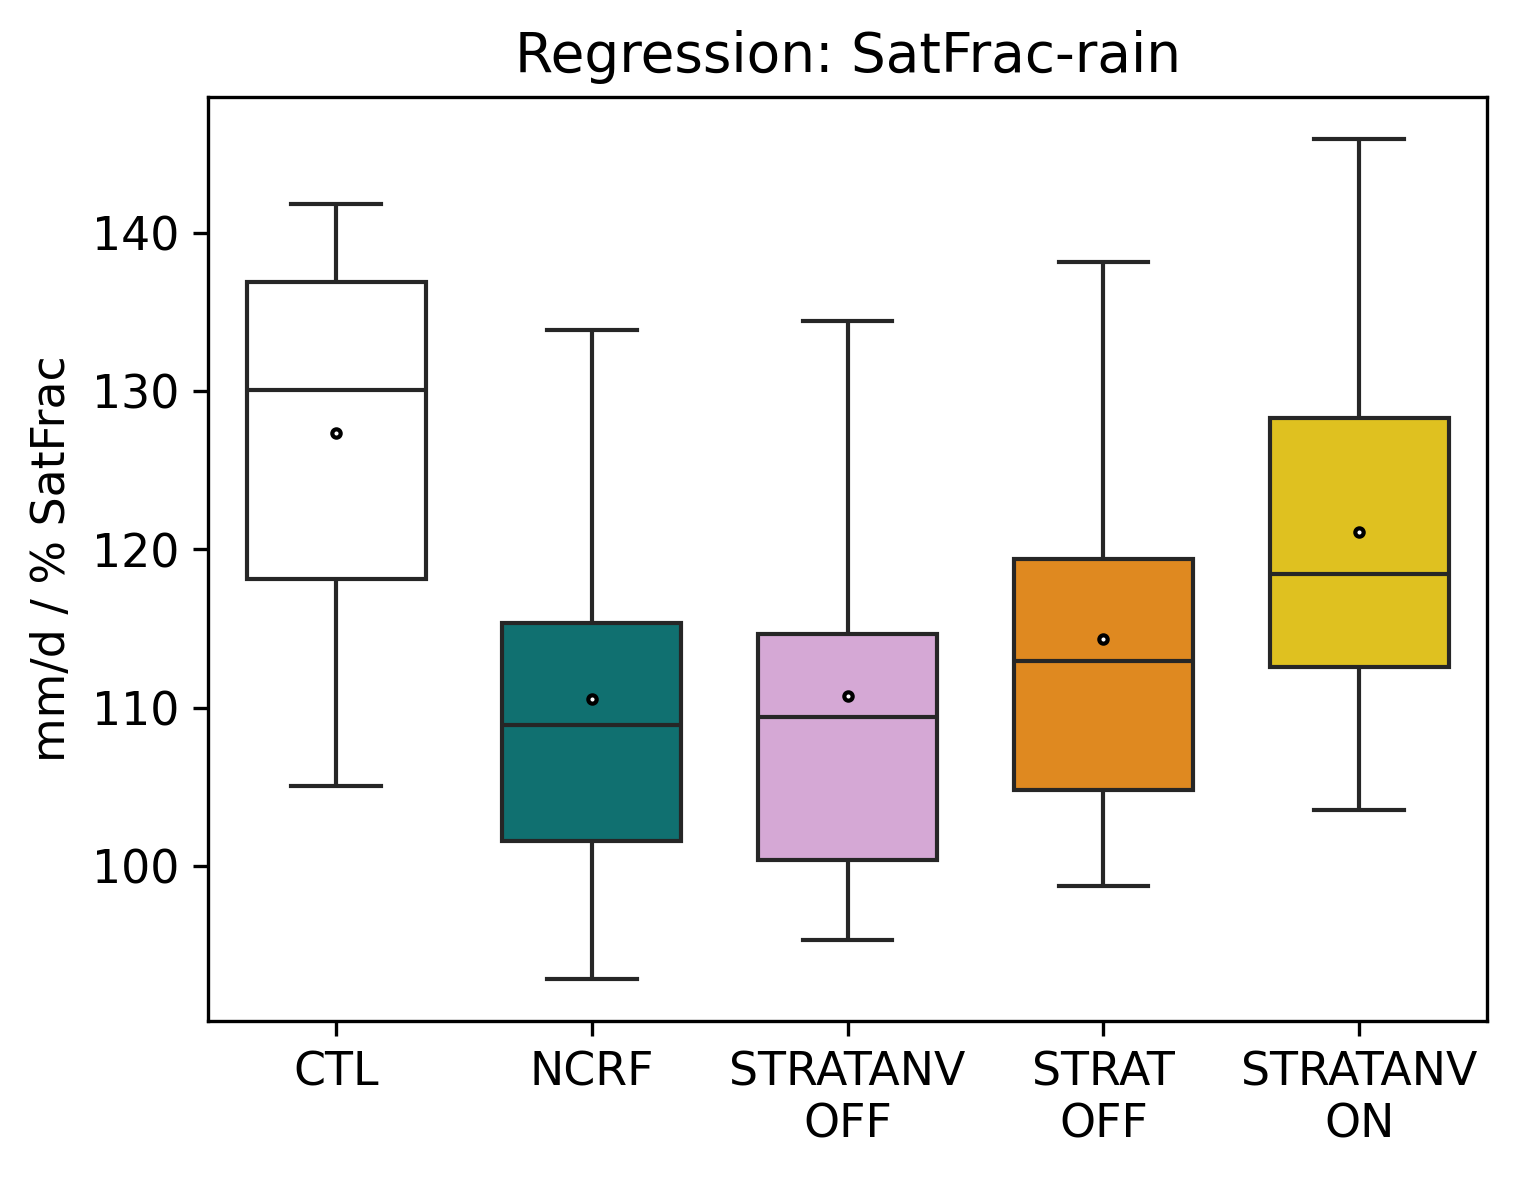

In [19]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: SatFrac-rain'
units_bp = 'mm/d / % SatFrac'

pw = get_var(allvars, 'pw')
pw_s = get_var(allvars, 'pw_sat')

rain = get_var(allvars, 'rain')

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

satfrac=[]
for itest in range(ntest):
    isatfrac=[]
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]
        isf = pw[itest][imemb]/pw_s[itest][imemb]
        isatfrac.append(isf)
    satfrac.append(isatfrac)

regression = get_regression(satfrac, rain)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


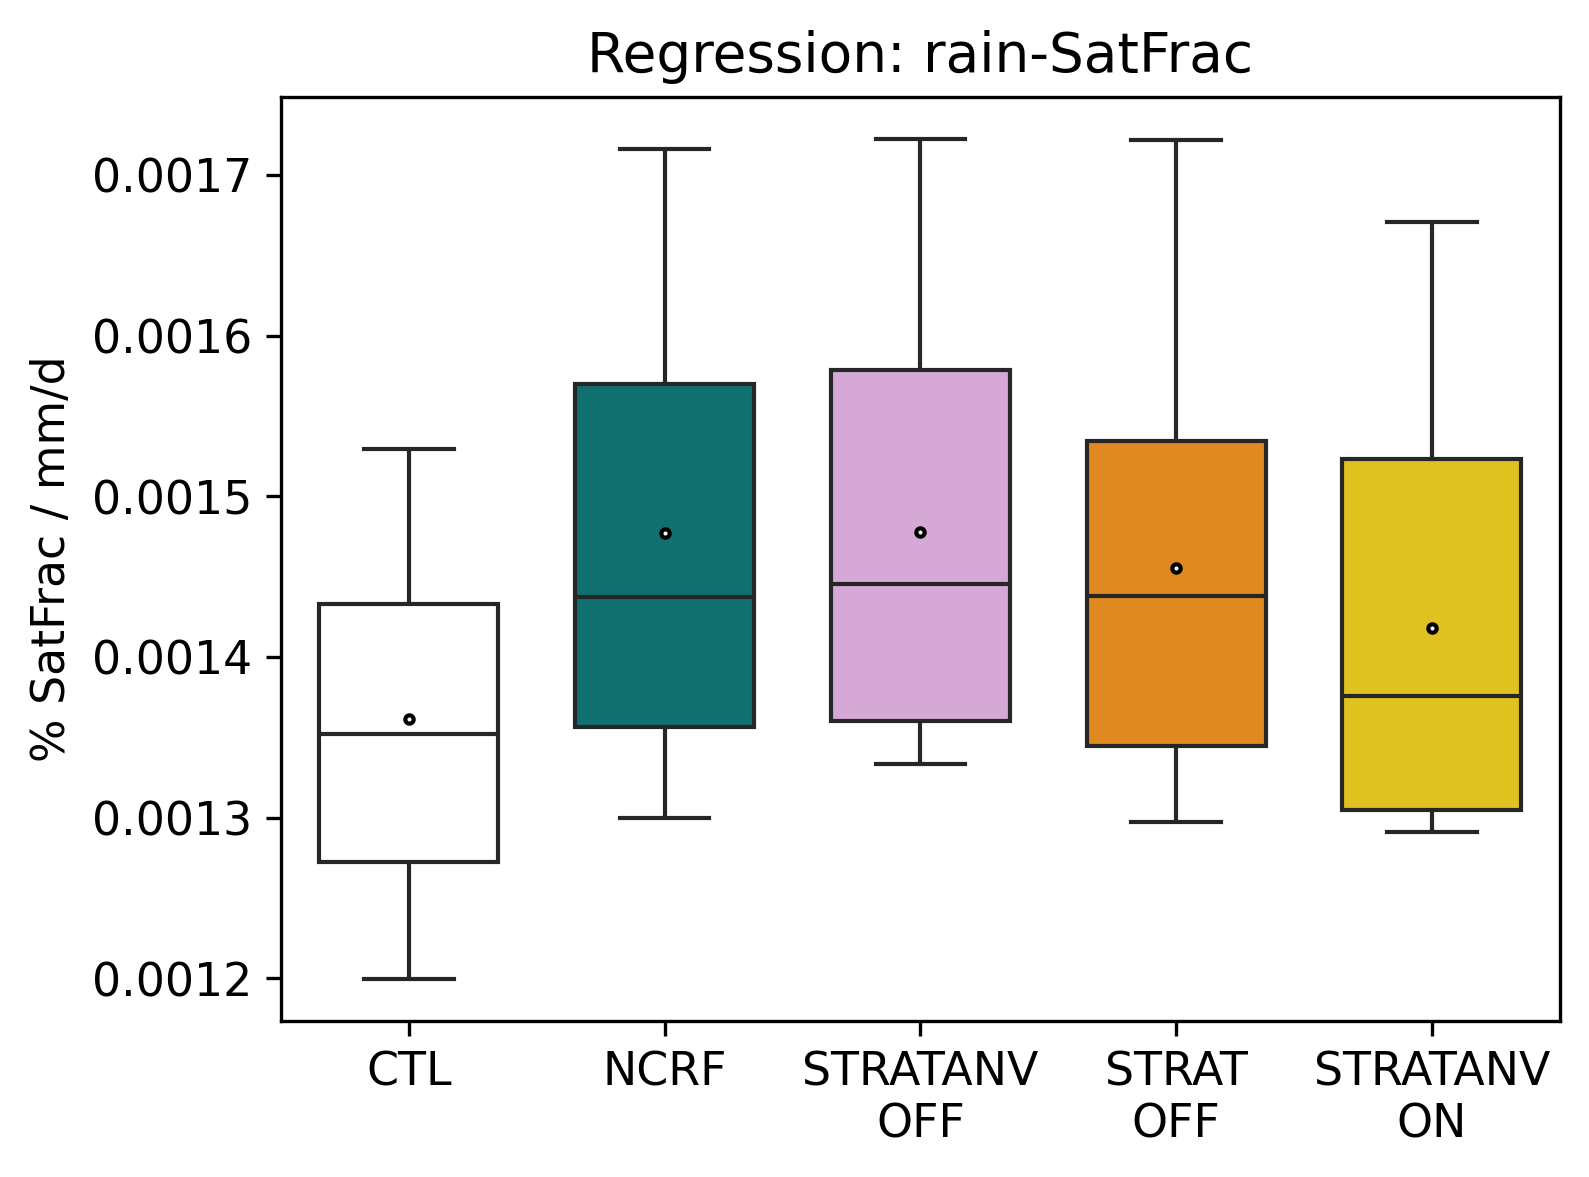

In [20]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: rain-SatFrac'
units_bp = '% SatFrac / mm/d'

pw = get_var(allvars, 'pw')
pw_s = get_var(allvars, 'pw_sat')

rain = get_var(allvars, 'rain')

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

satfrac=[]
for itest in range(ntest):
    isatfrac=[]
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]
        isf = pw[itest][imemb]/pw_s[itest][imemb]
        isatfrac.append(isf)
    satfrac.append(isatfrac)

regression = get_regression(rain, satfrac)

regression_boxplot(regression, tests_str, title_tag, units_bp)

/tmp/ipykernel_11741/3872806925.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


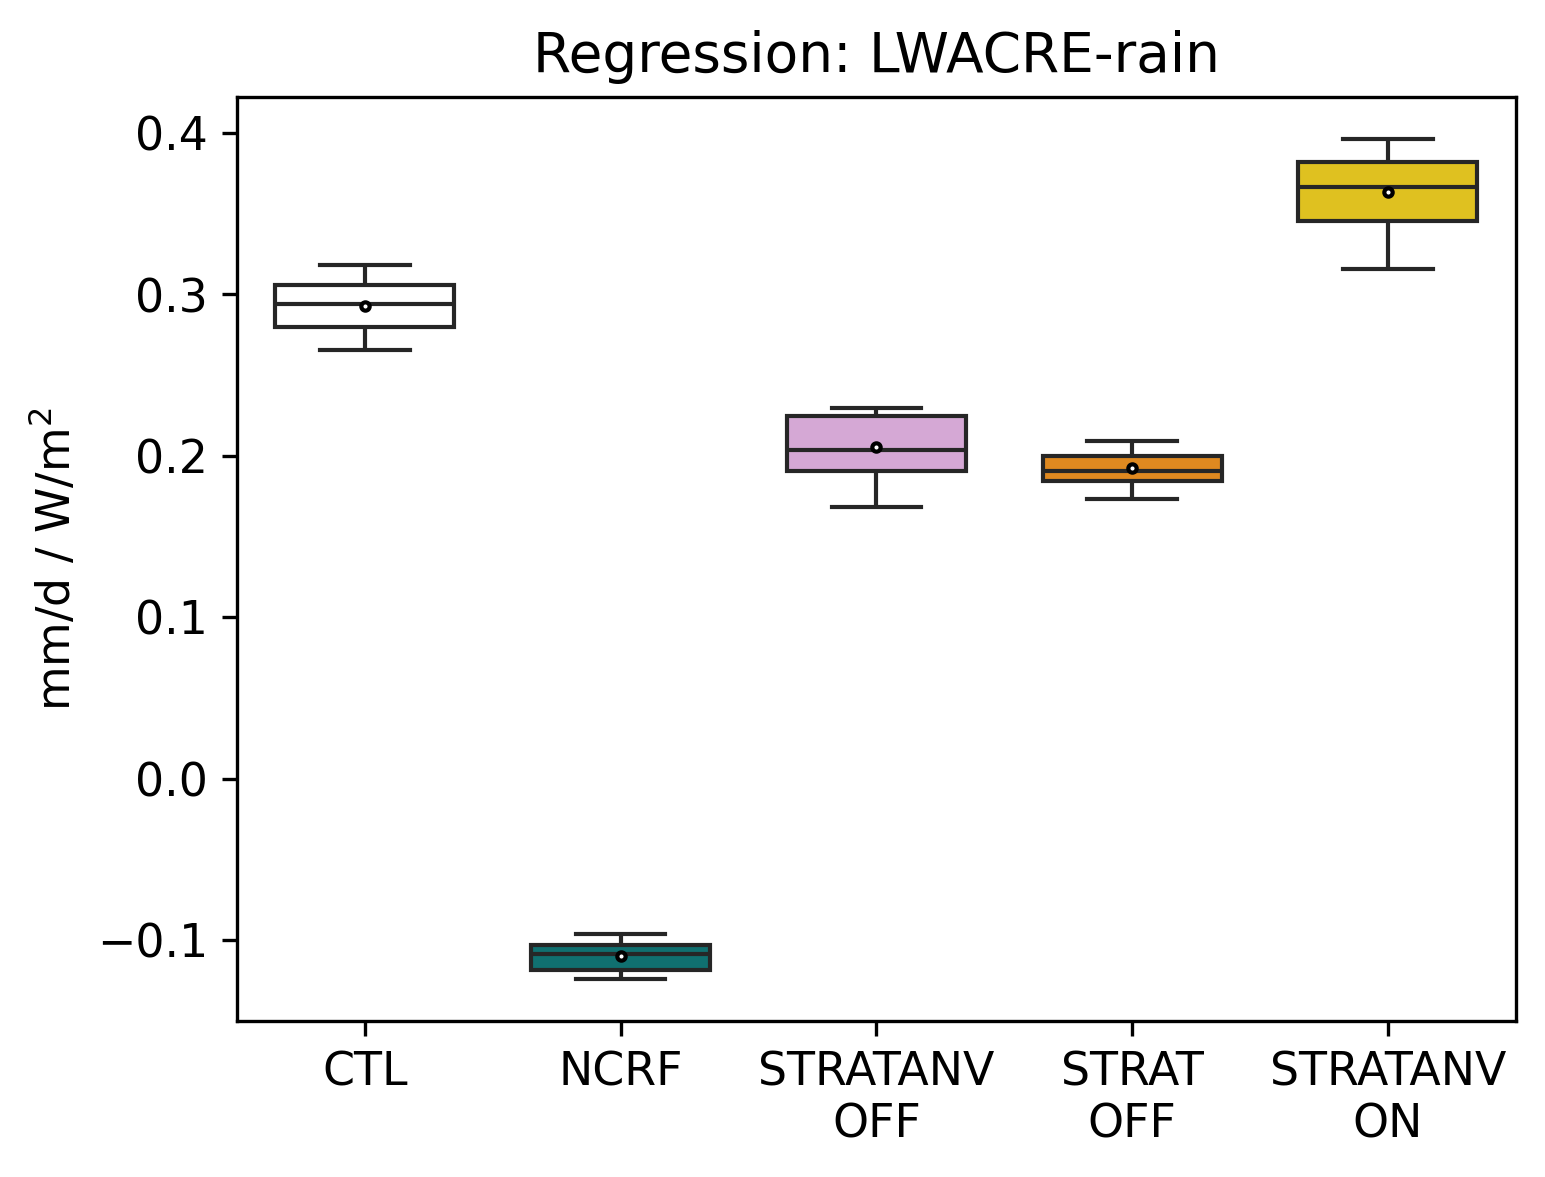

In [21]:
# Regressions and correlations
# a1 = (x'y')_bar / (x'^2)_bar
# units: y/x

title_tag = 'Regression: LWACRE-rain'
units_bp = 'mm/d / W/m$^2$'

pw = get_var(allvars, 'pw')
pw_s = get_var(allvars, 'pw_sat')

rain = get_var(allvars, 'rain')

lwacre = get_var(allvars, 'lwacre')
pclass_area = get_var(allvars, 'pclass_area')
kclass = 4 # stratiform

satfrac=[]
for itest in range(ntest):
    isatfrac=[]
    for imemb in range(nmem):
        # print(np.shape(imemb))
        tmpvar = np.array(pclass_area[itest][imemb])
        pclass_area[itest][imemb] = tmpvar[:,kclass,...]
        isf = pw[itest][imemb]/pw_s[itest][imemb]
        isatfrac.append(isf)
    satfrac.append(isatfrac)

regression = get_regression(lwacre, rain)

regression_boxplot(regression, tests_str, title_tag, units_bp)

---
#### Scatter plots

In [8]:
def scatter_get_var(allvars, str_name):
    str_ind = var_names.index(str_name)
    var_itest = []
    for imemb in allvars[0]:
        var_itest.append(imemb[str_ind])
    var_np=np.array(var_itest)
    var_np=np.mean(var_np,axis=0)
    return var_np.flatten()

In [9]:
def scatter_plot(var_x, var_y, name_x, name_y, var_names, units):

    str_ind_x = var_names.index(name_x)
    str_ind_y = var_names.index(name_y)

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    # fig_title = test_str.upper()+')'
    # ax.set_title(fig_title)

    ax.set_xlabel(var_names[str_ind_x]+' ['+units[str_ind_x]+']')
    # ax.set_xscale(log_x)

    ax.set_ylabel(var_names[str_ind_y]+' ['+units[str_ind_y]+']')

    plt.scatter(var_x, var_y)

    # plt.xlim(np.min(bins), np.max(bins))
    # plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()

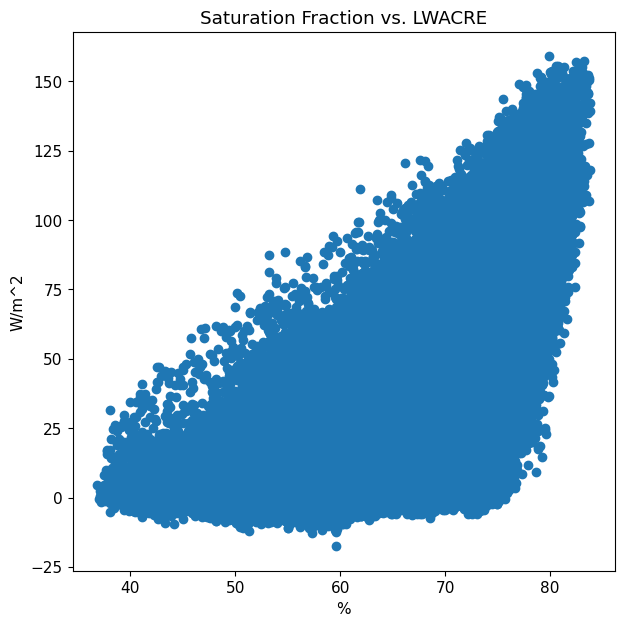

In [10]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'lwacre'

plot_1 = scatter_get_var(allvars, name_1)
plot_2 = scatter_get_var(allvars, name_2)
plot_x = plot_1/plot_2*1e2

plot_y = scatter_get_var(allvars, name_y)

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. LWACRE'
ax.set_title(fig_title)

ax.set_xlabel('%')
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

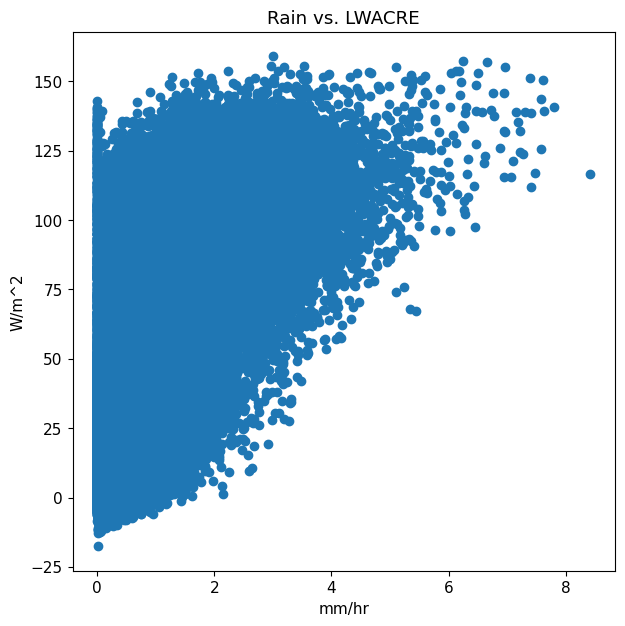

In [12]:
name_x = 'rain'
name_y = 'lwacre'

plot_x = scatter_get_var(allvars, name_x)/24
plot_y = scatter_get_var(allvars, name_y)

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Rain vs. LWACRE'
ax.set_title(fig_title)

ax.set_xlabel('mm/hr')
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

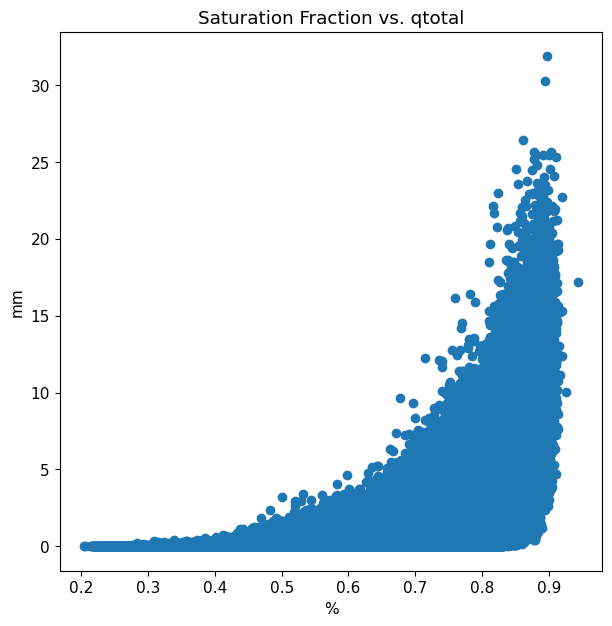

In [78]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'qtotal'

plot_1 = get_array(allvars, name_1)
plot_2 = get_array(allvars, name_2)
plot_x = plot_1/plot_2

plot_y = get_array(allvars, name_y)

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. qtotal'
ax.set_title(fig_title)

ax.set_xlabel('%')
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

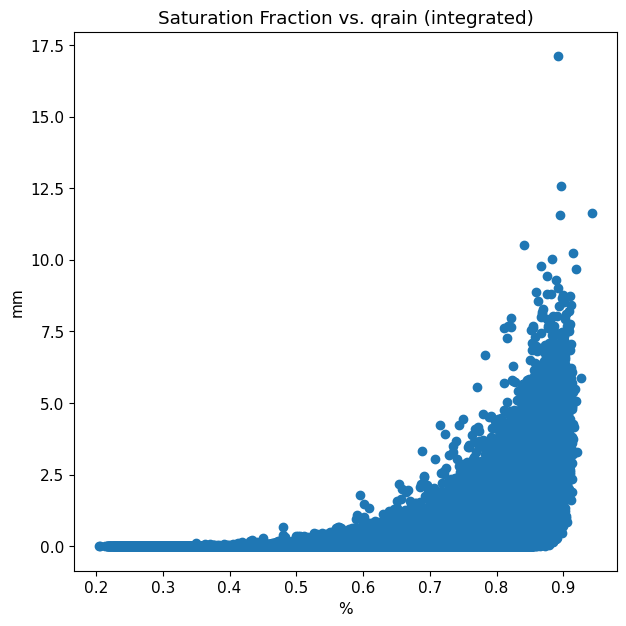

In [87]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'qrain'

plot_1 = get_array(allvars, name_1)
plot_2 = get_array(allvars, name_2)
plot_x = plot_1/plot_2

plot_y = get_array(allvars, name_y)

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. qrain (integrated)'
ax.set_title(fig_title)

ax.set_xlabel('%')
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

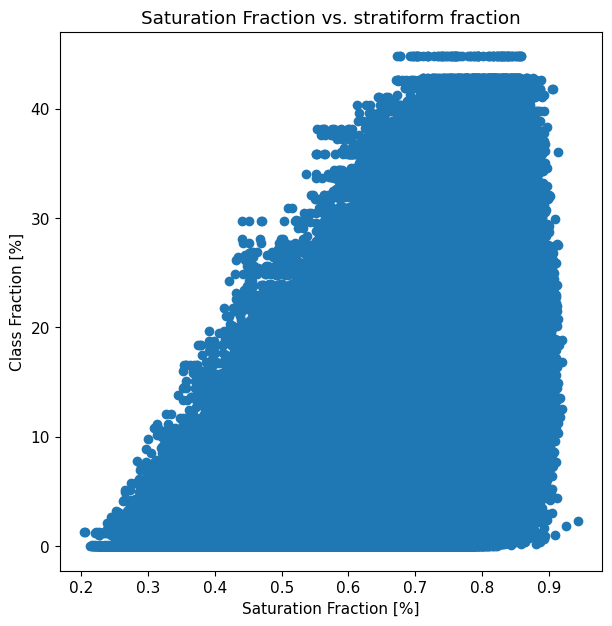

In [95]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'pclass_area'

plot_1 = get_array(allvars, name_1)
plot_2 = get_array(allvars, name_2)
plot_x = plot_1/plot_2

plot_y = get_array(allvars, name_y)
plot_y = plot_y[:,:,4,:,:] # 4 = stratiform

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. stratiform fraction'
ax.set_title(fig_title)

ax.set_xlabel('Saturation Fraction [%]')
# ax.set_xscale(log_x)

ax.set_ylabel('Class Fraction ['+units[str_ind_y]+']')

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

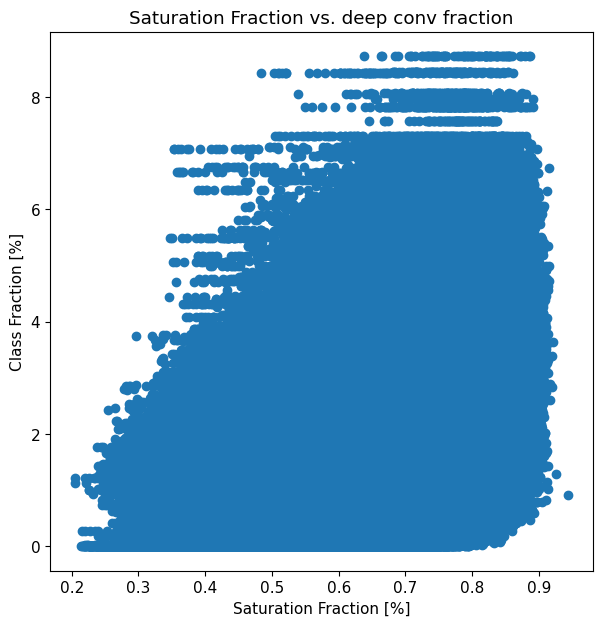

In [96]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'pclass_area'

plot_1 = get_array(allvars, name_1)
plot_2 = get_array(allvars, name_2)
plot_x = plot_1/plot_2

plot_y = get_array(allvars, name_y)
plot_y = plot_y[:,:,1,:,:] # 1 = deep

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. deep conv fraction'
ax.set_title(fig_title)

ax.set_xlabel('Saturation Fraction [%]')
# ax.set_xscale(log_x)

ax.set_ylabel('Class Fraction ['+units[str_ind_y]+']')

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

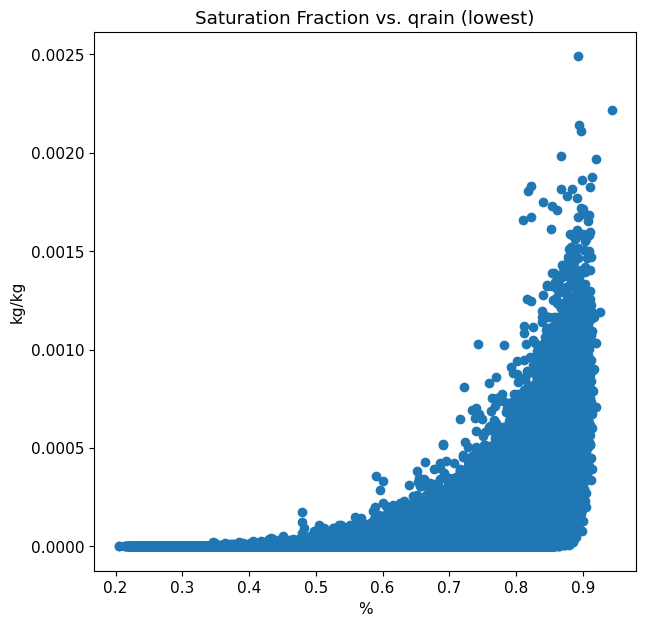

In [88]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'qrain_z'

plot_1 = get_array(allvars, name_1)
plot_2 = get_array(allvars, name_2)
plot_x = plot_1/plot_2

plot_y = get_array(allvars, name_y)

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. qrain (lowest)'
ax.set_title(fig_title)

ax.set_xlabel('%')
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

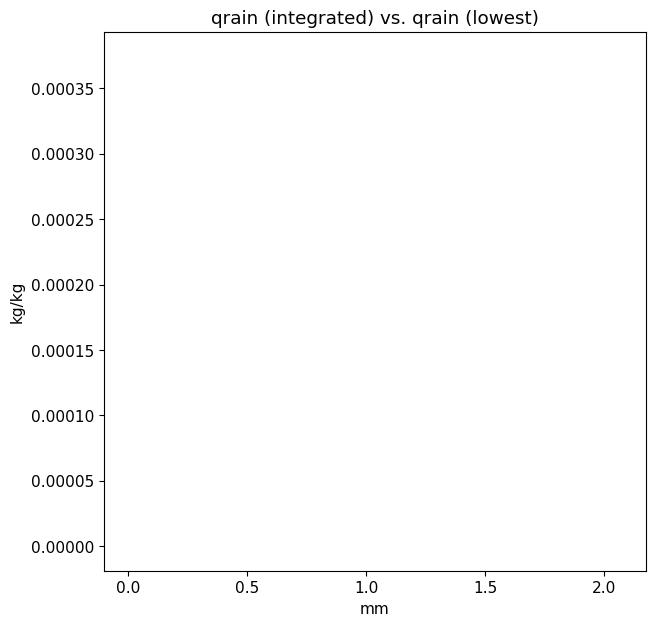

In [53]:
name_x = 'qrain'
name_y = 'qrain_z'

plot_x = scatter_get_var(allvars, name_x)
plot_y = scatter_get_var(allvars, name_y)

str_ind_x = var_names.index(name_x)
str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'qrain (integrated) vs. qrain (lowest)'
ax.set_title(fig_title)

ax.set_xlabel(units[str_ind_x])
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

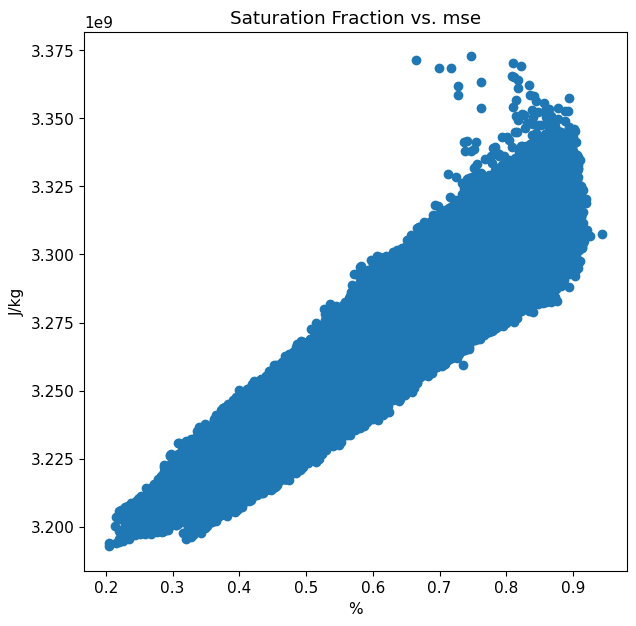

In [80]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'mse_vint'

plot_1 = get_array(allvars, name_1)
plot_2 = get_array(allvars, name_2)
plot_x = plot_1/plot_2

plot_y = get_array(allvars, name_y)

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. mse'
ax.set_title(fig_title)

ax.set_xlabel('%')
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

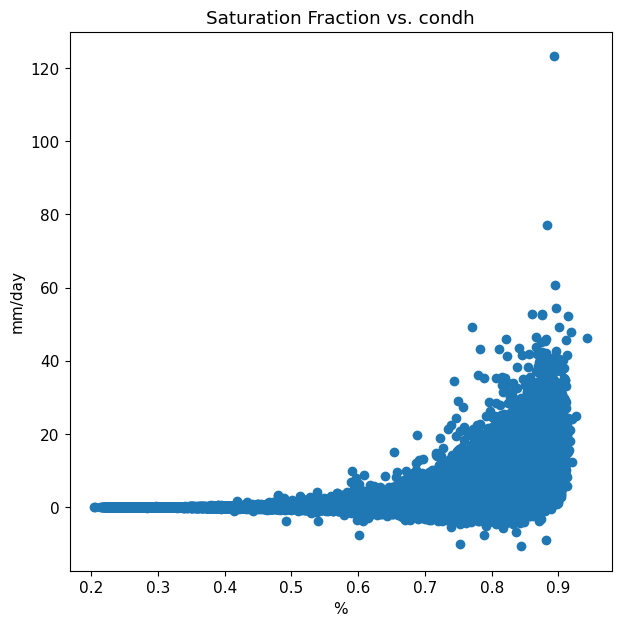

In [82]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'condh'

plot_1 = get_array(allvars, name_1)
plot_2 = get_array(allvars, name_2)
plot_x = plot_1/plot_2

plot_y = get_array(allvars, name_y)

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. condh'
ax.set_title(fig_title)

ax.set_xlabel('%')
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

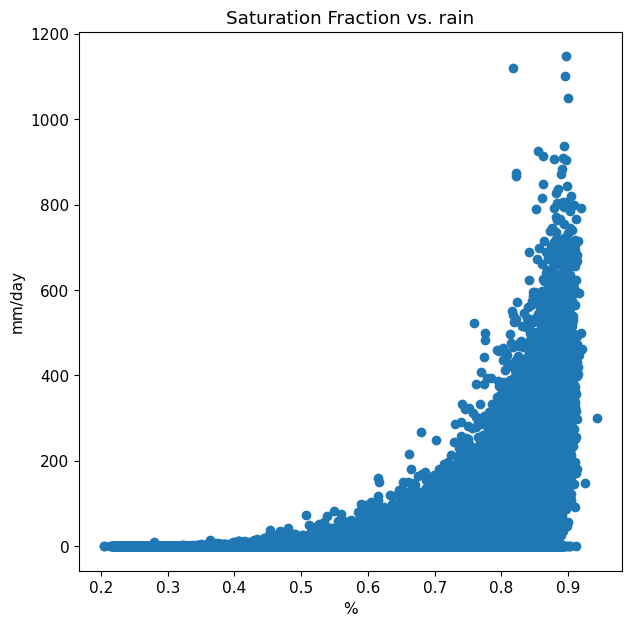

In [85]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'rain'

plot_1 = get_array(allvars, name_1)
plot_2 = get_array(allvars, name_2)
plot_x = plot_1/plot_2

plot_y = get_array(allvars, name_y)

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. rain'
ax.set_title(fig_title)

ax.set_xlabel('%')
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

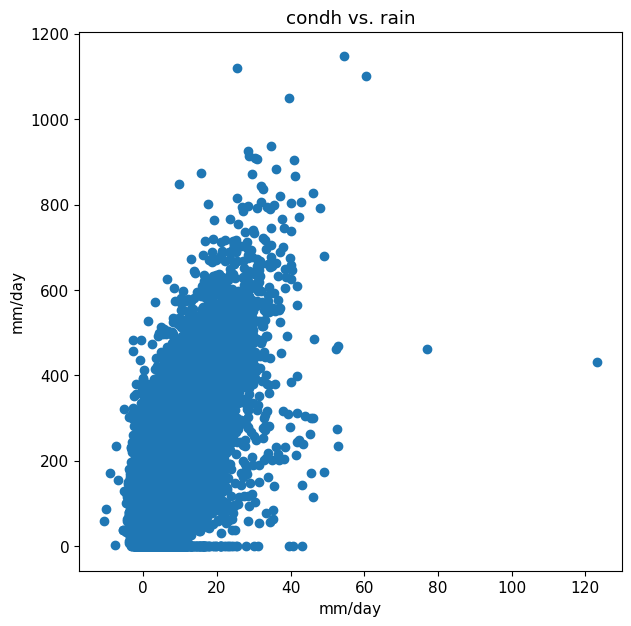

In [84]:
name_x = 'condh'
name_y = 'rain'

plot_x = get_array(allvars, name_x)
plot_y = get_array(allvars, name_y)

str_ind_x = var_names.index(name_x)
str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'condh vs. rain'
ax.set_title(fig_title)

ax.set_xlabel(units[str_ind_x])
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

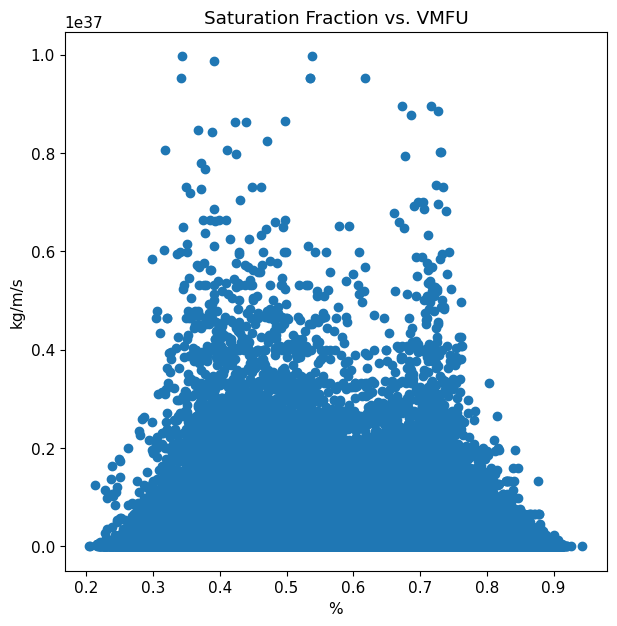

In [77]:
name_1 = 'pw'
name_2 = 'pw_sat'
name_y = 'vmfu'

plot_1 = get_array(allvars, name_1)
plot_2 = get_array(allvars, name_2)
plot_x = plot_1/plot_2

plot_y = get_array(allvars, name_y)

str_ind_y = var_names.index(name_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

fig_title = 'Saturation Fraction vs. VMFU'
ax.set_title(fig_title)

ax.set_xlabel('%')
# ax.set_xscale(log_x)

ax.set_ylabel(units[str_ind_y])

plt.scatter(plot_x, plot_y)

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 0.020)

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()